In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

2024-12-30 20:58:29.007385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735567109.025160  406928 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735567109.030496  406928 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 20:58:29.048348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMG_SIZE = (600, 600)  # Increased for B7
BATCH_SIZE = 4  # Reduced for B7
DATA_DIR = "split_images"

In [3]:
# Cell 3 - Data Generators
def create_generators():
    # Enhanced data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest',
        validation_split=0.2
    )
    
    # Only rescaling for validation
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset='training',
        shuffle=True
    )
    
    # Validation generator
    valid_generator = valid_datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset='validation',
        shuffle=False
    )
    
    return train_generator, valid_generator


In [4]:

# Example Usage
# data_dir = "split_images"
# target_class = "3"
# target_size = 2500
# image_size = (600, 600)
# batch_size = 32
# seed = 42 

train_generator, valid_generator = create_generators()


Found 17120 images belonging to 5 classes.
Found 4277 images belonging to 5 classes.


In [5]:
# Get class indices and counts for training data
train_classes = train_generator.classes
train_counts = Counter(train_classes)
print("Training Data Class Distribution:", train_counts)

# Get class indices and counts for validation data
validation_classes = valid_generator.classes
validation_counts = Counter(validation_classes)
print("Validation Data Class Distribution:", validation_counts)

# # Get class indices and counts for test data
# test_classes = test_generator.classes
# test_counts = Counter(test_classes)
# print("Test Data Class Distribution:", test_counts)


Training Data Class Distribution: Counter({np.int32(3): 10527, np.int32(4): 2062, np.int32(2): 1909, np.int32(1): 1752, np.int32(0): 870})
Validation Data Class Distribution: Counter({np.int32(3): 2631, np.int32(4): 515, np.int32(2): 477, np.int32(1): 437, np.int32(0): 217})


In [6]:
model = load_model("cassava_model_b7.keras")

I0000 00:00:1735567119.980157  406928 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6691 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:23:00.0, compute capability: 6.1
/home/bleckha/projects/viskom/tf217/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1432 variables whereas the saved optimizer has 1436 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [7]:
# Model Evaluation
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

/home/bleckha/projects/viskom/tf217/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1735567142.873221  407045 service.cc:148] XLA service 0x7fda440e6d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735567142.873826  407045 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-12-30 20:59:03.350017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735567145.124743  407045 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-30 20:59:11.100132: E ext

1070/1070 ━━━━━━━━━━━━━━━━━━━━ 286s 241ms/step - accuracy: 0.8076 - loss: 0.6513
Validation Accuracy: 86.72%


1070/1070 ━━━━━━━━━━━━━━━━━━━━ 256s 239ms/step - accuracy: 0.8076 - loss: 0.6513
Test Loss: 0.4318176507949829
Test Accuracy: 0.8671966195106506
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 288s 256ms/step
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.71      0.65       217
           1       0.86      0.66      0.75       437
           2       0.74      0.84      0.79       477
           3       0.97      0.94      0.96      2631
           4       0.66      0.74      0.70       515

    accuracy                           0.87      4277
   macro avg       0.77      0.78      0.77      4277
weighted avg       0.88      0.87      0.87      4277



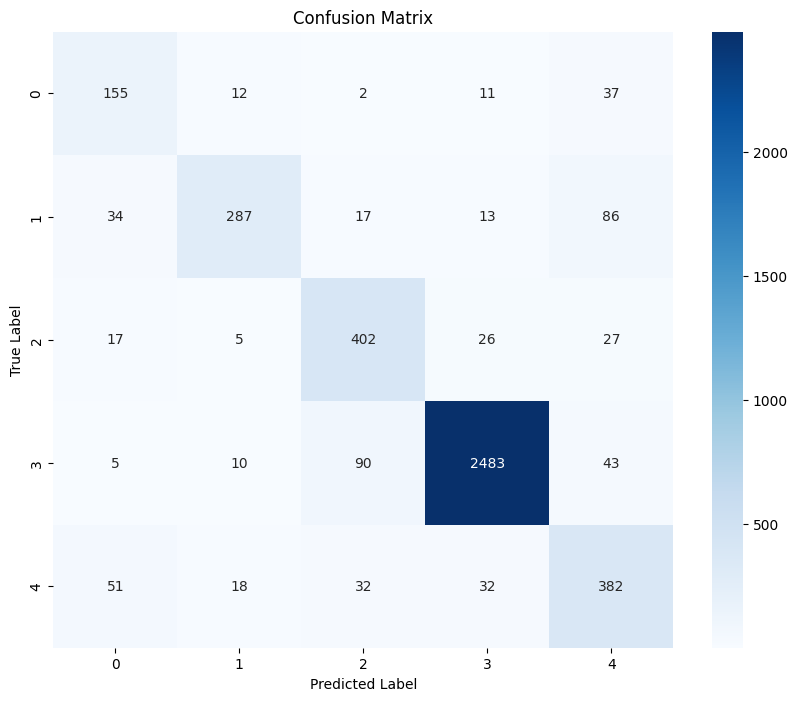

In [ ]:
# Evaluate the model on the test set
results = model.evaluate(valid_generator)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Predictions for the test set
test_predictions = model.predict(valid_generator)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Get true labels from the generator
true_classes = valid_generator.classes

# Get class names
class_names = list(valid_generator.class_indices.keys())

# Ensure the number of predictions and true labels match
num_test_samples = len(valid_generator.filenames)
test_predicted_classes = test_predicted_classes[:num_test_samples]
true_classes = true_classes[:num_test_samples]

# Classification report for the test set
print("Test Classification Report:")
print(classification_report(true_classes, test_predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, test_predicted_classes)

# plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

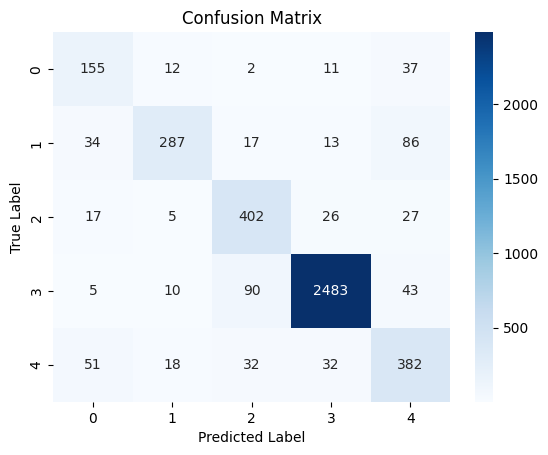

In [14]:
# Confusion matrix
cm = confusion_matrix(true_classes, test_predicted_classes)

# plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

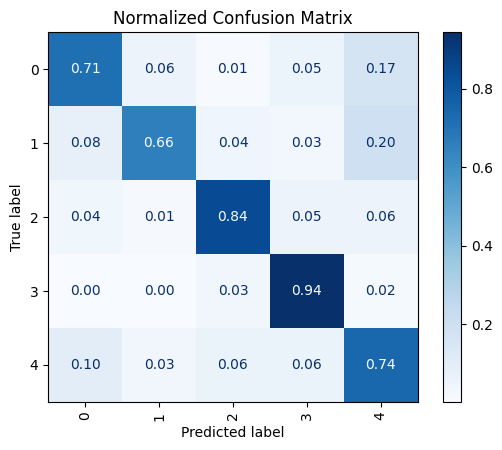

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# If you want normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_normalized.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
plt.title("Normalized Confusion Matrix")
plt.show()

NameError: name 'history' is not defined

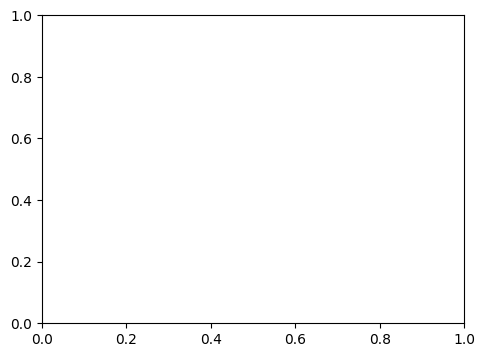

In [9]:

# Training results visualiza
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Could be because of Dropout values. Instead of undersampling, you can oversampled. or maybe take the midlle road where you undersample the most classes and oversmaple the rest to reach the medium amopunt in this case around 5-8k images per class

i want to also check images in each dataset. train, val, test for each class